In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

load preprocessed data


In [32]:


# Load your engineered data
df = pd.read_csv('data/engineered_data.csv')

print(f"Loaded: {df.shape[0]:,} rows, {df.shape[1]:,} columns")
print(f"\n All columns in dataset:")
print("="*70)
for i, col in enumerate(df.columns, 1):
    print(f"{i:3d}. {col}")

Loaded: 195,196 rows, 59 columns

 All columns in dataset:
  1. NACCID
  2. NACCADC
  3. PACKET
  4. FORMVER
  5. VISITMO
  6. VISITDAY
  7. VISITYR
  8. NACCVNUM
  9. NACCAVST
 10. NACCNVST
 11. NACCDAYS
 12. NACCFDYS
 13. BIRTHMO
 14. BIRTHYR
 15. NACCAGE
 16. NACCAGEB
 17. SEX
 18. HISPANIC
 19. RACE
 20. NACCNIHR
 21. PRIMLANG
 22. EDUC
 23. MARISTAT
 24. NACCLIVS
 25. INDEPEND
 26. RESIDENC
 27. HANDED
 28. NACCREAS
 29. NACCREFR
 30. INBIRMO
 31. INBIRYR
 32. INSEX
 33. NEWINF
 34. INRELTO
 35. INLIVWTH
 36. NACCFAM
 37. NACCMOM
 38. NACCFADM
 39. NACCAM
 40. NACCFFTD
 41. NACCFM
 42. NACCBMI
 43. NACCUDSD
 44. age_squared
 45. age_cubed
 46. age_group_65
 47. age_group_75
 48. age_group_85
 49. low_education
 50. high_education
 51. age_edu_interaction
 52. age_edu_ratio
 53. social_isolation_score
 54. family_risk_score
 55. has_family_history
 56. years_in_study
 57. months_in_study
 58. avg_days_between_visits
 59. DEMENTED


REMOVING ID AND NON-PREDICTIVE COLUMNS

In [33]:


# Columns to remove from YOUR specific dataset
COLUMNS_TO_REMOVE = [
    # ID columns (not predictive)
    'NACCID',       # Subject ID
    'NACCADC',      # ADC center ID
    
    # Administrative (not predictive)
    'PACKET',       # Packet type
    'FORMVER',      # Form version
    
    # Visit identifiers (not predictive, just administrative)
    'VISITMO',      # Visit month
    'VISITDAY',     # Visit day
    'VISITYR',      # Visit year
    'NACCVNUM',     # Visit number
    'NACCAVST',     # Visit status
    'NACCNVST',     # Next visit
    
    # Birth date (we already have NACCAGE)
    'BIRTHMO',      # Birth month
    'BIRTHYR',      # Birth year
    
    # Informant birth date (not useful)
    'INBIRMO',      # Informant birth month
    'INBIRYR',      # Informant birth year
    
    # CRITICAL: Diagnosis-related column (POTENTIAL LEAKAGE)
    'NACCUDSD',     # UDS diagnosis - might contain outcome info
    
    # Other administrative
    'NACCREAS',     # Reason for visit
    'NACCREFR',     # Referral source
]



columns_found = []
columns_not_found = []

for col in COLUMNS_TO_REMOVE:
    if col in df.columns:
        columns_found.append(col)
        print(f"   Found: {col} - WILL REMOVE")
    else:
        columns_not_found.append(col)

if columns_not_found:
    print(f"\nNot in dataset (OK):")
    for col in columns_not_found:
        print(f"   - {col}")

# Remove the columns
if columns_found:
    print(f"\n  Removing {len(columns_found)} columns:")
    for col in columns_found:
        print(f"   - {col}")
    
    df = df.drop(columns=columns_found)
    print(f"\n Removed! New shape: {df.shape}")
else:
    print(f"\n  No columns to remove (they may have been removed already)")

print(f"\n Remaining columns: {df.shape[1]}")


# Show remaining columns
print(f"\n Columns after removal:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:3d}. {col}")

   Found: NACCID - WILL REMOVE
   Found: NACCADC - WILL REMOVE
   Found: PACKET - WILL REMOVE
   Found: FORMVER - WILL REMOVE
   Found: VISITMO - WILL REMOVE
   Found: VISITDAY - WILL REMOVE
   Found: VISITYR - WILL REMOVE
   Found: NACCVNUM - WILL REMOVE
   Found: NACCAVST - WILL REMOVE
   Found: NACCNVST - WILL REMOVE
   Found: BIRTHMO - WILL REMOVE
   Found: BIRTHYR - WILL REMOVE
   Found: INBIRMO - WILL REMOVE
   Found: INBIRYR - WILL REMOVE
   Found: NACCUDSD - WILL REMOVE
   Found: NACCREAS - WILL REMOVE
   Found: NACCREFR - WILL REMOVE

  Removing 17 columns:
   - NACCID
   - NACCADC
   - PACKET
   - FORMVER
   - VISITMO
   - VISITDAY
   - VISITYR
   - NACCVNUM
   - NACCAVST
   - NACCNVST
   - BIRTHMO
   - BIRTHYR
   - INBIRMO
   - INBIRYR
   - NACCUDSD
   - NACCREAS
   - NACCREFR

 Removed! New shape: (195196, 42)

 Remaining columns: 42

 Columns after removal:
  1. NACCDAYS
  2. NACCFDYS
  3. NACCAGE
  4. NACCAGEB
  5. SEX
  6. HISPANIC
  7. RACE
  8. NACCNIHR
  9. PRIMLANG
 

identifying target variable

In [34]:


# For your dataset, the target is DEMENTED
TARGET = 'DEMENTED'

if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found in dataset!")

print(f" Target found: {TARGET}")

# Show target distribution
print(f"\n Target distribution:")
target_counts = df[TARGET].value_counts()
print(target_counts)

print(f"\nPercentages:")
target_pct = df[TARGET].value_counts(normalize=True) * 100
print(target_pct)

# Check class balance
min_class_pct = target_pct.min()
if min_class_pct < 30:
    print(f"\n  Class imbalance detected! Minority class: {min_class_pct:.1f}%")
    print(f"   Will use stratified split to maintain balance")
else:
    print(f"\n Classes reasonably balanced")

# Check for missing values in target
missing_target = df[TARGET].isna().sum()
if missing_target > 0:
    print(f"\n  {missing_target} rows have missing target - will be removed")

# Separate features and target
X = df.drop(columns=[TARGET])
y = df[TARGET]

print(f"\n Separating features and target...")
print(f"   Before: {len(df)} rows")

# Remove rows with missing target
valid_idx = y.notna()
X = X[valid_idx]
y = y[valid_idx]

print(f"   After removing missing target: {len(X)} rows")

print(f"\n Separated successfully!")
print(f"   X (features): {X.shape[0]:,} rows × {X.shape[1]:,} columns")
print(f"   y (target): {len(y):,} samples")


print(f"FINAL FEATURES ({len(X.columns)} columns):")

for i, col in enumerate(X.columns, 1):
    print(f"{i:3d}. {col}")




 Target found: DEMENTED

 Target distribution:
DEMENTED
0    137606
1     57590
Name: count, dtype: int64

Percentages:
DEMENTED
0    70.496322
1    29.503678
Name: proportion, dtype: float64

  Class imbalance detected! Minority class: 29.5%
   Will use stratified split to maintain balance

 Separating features and target...
   Before: 195196 rows
   After removing missing target: 195196 rows

 Separated successfully!
   X (features): 195,196 rows × 41 columns
   y (target): 195,196 samples
FINAL FEATURES (41 columns):
  1. NACCDAYS
  2. NACCFDYS
  3. NACCAGE
  4. NACCAGEB
  5. SEX
  6. HISPANIC
  7. RACE
  8. NACCNIHR
  9. PRIMLANG
 10. EDUC
 11. MARISTAT
 12. NACCLIVS
 13. INDEPEND
 14. RESIDENC
 15. HANDED
 16. INSEX
 17. NEWINF
 18. INRELTO
 19. INLIVWTH
 20. NACCFAM
 21. NACCMOM
 22. NACCFADM
 23. NACCAM
 24. NACCFFTD
 25. NACCFM
 26. NACCBMI
 27. age_squared
 28. age_cubed
 29. age_group_65
 30. age_group_75
 31. age_group_85
 32. low_education
 33. high_education
 34. age_edu_i

In [35]:


# Columns to remove from YOUR specific dataset
COLUMNS_TO_REMOVE = [
    # ID columns (not predictive)
    'NACCID',       # Subject ID
    'NACCADC',      # ADC center ID
    
    # Administrative (not predictive)
    'PACKET',       # Packet type
    'FORMVER',      # Form version
    
    # Visit identifiers (not predictive, just administrative)
    'VISITMO',      # Visit month
    'VISITDAY',     # Visit day
    'VISITYR',      # Visit year
    'NACCVNUM',     # Visit number
    'NACCAVST',     # Visit status
    'NACCNVST',     # Next visit
    
    # Birth date (we already have NACCAGE)
    'BIRTHMO',      # Birth month
    'BIRTHYR',      # Birth year
    
    # Informant birth date (not useful)
    'INBIRMO',      # Informant birth month
    'INBIRYR',      # Informant birth year
    
    # CRITICAL: Diagnosis-related column (POTENTIAL LEAKAGE)
    'NACCUDSD',     # UDS diagnosis - might contain outcome info
    
    # Other administrative
    'NACCREAS',     # Reason for visit
    'NACCREFR',     # Referral source
]



columns_found = []
columns_not_found = []

for col in COLUMNS_TO_REMOVE:
    if col in df.columns:
        columns_found.append(col)
        print(f"   Found: {col} - WILL REMOVE")
    else:
        columns_not_found.append(col)

if columns_not_found:
    print(f"\nNot in dataset (OK):")
    for col in columns_not_found:
        print(f"   - {col}")

# Remove the columns
if columns_found:
    print(f"\n  Removing {len(columns_found)} columns:")
    for col in columns_found:
        print(f"   - {col}")
    
    df = df.drop(columns=columns_found)
    print(f"\n Removed! New shape: {df.shape}")
else:
    print(f"\n  No columns to remove (they may have been removed already)")

print(f"\n Remaining columns: {df.shape[1]}")


# Show remaining columns
print(f"\n Columns after removal:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:3d}. {col}")


Not in dataset (OK):
   - NACCID
   - NACCADC
   - PACKET
   - FORMVER
   - VISITMO
   - VISITDAY
   - VISITYR
   - NACCVNUM
   - NACCAVST
   - NACCNVST
   - BIRTHMO
   - BIRTHYR
   - INBIRMO
   - INBIRYR
   - NACCUDSD
   - NACCREAS
   - NACCREFR

  No columns to remove (they may have been removed already)

 Remaining columns: 42

 Columns after removal:
  1. NACCDAYS
  2. NACCFDYS
  3. NACCAGE
  4. NACCAGEB
  5. SEX
  6. HISPANIC
  7. RACE
  8. NACCNIHR
  9. PRIMLANG
 10. EDUC
 11. MARISTAT
 12. NACCLIVS
 13. INDEPEND
 14. RESIDENC
 15. HANDED
 16. INSEX
 17. NEWINF
 18. INRELTO
 19. INLIVWTH
 20. NACCFAM
 21. NACCMOM
 22. NACCFADM
 23. NACCAM
 24. NACCFFTD
 25. NACCFM
 26. NACCBMI
 27. age_squared
 28. age_cubed
 29. age_group_65
 30. age_group_75
 31. age_group_85
 32. low_education
 33. high_education
 34. age_edu_interaction
 35. age_edu_ratio
 36. social_isolation_score
 37. family_risk_score
 38. has_family_history
 39. years_in_study
 40. months_in_study
 41. avg_days_between_

Current data state

In [46]:



# Data types
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\n   Numeric columns: {len(numeric_cols)}")
print(f"   Non-numeric columns: {len(non_numeric_cols)}")

# Step 2: Handle non-numeric columns
if non_numeric_cols:
    print(f"\nStep 2: Encoding non-numeric columns...")
    print(f"   Found {len(non_numeric_cols)} non-numeric columns:")
    
    for col in non_numeric_cols:
        n_unique = X[col].nunique()
        print(f"      - {col}: {n_unique} unique values")
    
    # Only encode columns with reasonable number of categories
    low_card = [c for c in non_numeric_cols if X[c].nunique() <= 15]
    high_card = [c for c in non_numeric_cols if X[c].nunique() > 15]
    
    if low_card:
        print(f"\n   Encoding {len(low_card)} low-cardinality columns...")
        X = pd.get_dummies(X, columns=low_card, drop_first=True)
        print(f"    Encoded! New shape: {X.shape}")
    
    if high_card:
        print(f"\n   ⚠️  Removing {len(high_card)} high-cardinality columns:")
        for col in high_card:
            print(f"      - {col}")
        X = X.drop(columns=high_card)
else:
    print("\nStep 2: All columns are numeric ")

# Step 3: Handle infinite values
print(f"\nStep 3: Checking for infinite values...")
inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
if inf_count > 0:
    print(f"   Found {inf_count} infinite values, replacing with NaN...")
    X = X.replace([np.inf, -np.inf], np.nan)
    print(f"    Replaced infinite values")
else:
    print(f"    No infinite values")

# Step 4: Handle missing values
print(f"\nStep 4: Handling missing values...")
missing_count = X.isnull().sum().sum()
missing_pct = (missing_count / (X.shape[0] * X.shape[1])) * 100

print(f"   Missing: {missing_count:,} ({missing_pct:.2f}%)")

if missing_count > 0:
    # Show top missing columns
    missing_by_col = X.isnull().sum().sort_values(ascending=False)
    missing_cols = missing_by_col[missing_by_col > 0]
    
    print(f"\n   Top 10 columns with missing values:")
    for col, count in missing_cols.head(10).items():
        pct = (count / len(X)) * 100
        print(f"      - {col}: {count} ({pct:.1f}%)")
    
    # Impute
    print(f"\n   Imputing with median...")
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)
    
    print(f"   Imputation complete!")
    print(f"   Remaining missing: {X.isnull().sum().sum()}")
else:
    print(f"    No missing values!")

print(f"\nStep 5: Final preprocessing check...")
print(f"   Shape: {X.shape}")
print(f"   All numeric: {X.select_dtypes(include=[np.number]).shape[1] == X.shape[1]}")
print(f"   No missing: {X.isnull().sum().sum() == 0}")
print(f"   No infinite: {np.isinf(X).sum().sum() == 0}")

print(f"   Final features: {X.shape[1]}")



   Numeric columns: 41
   Non-numeric columns: 0

Step 2: All columns are numeric 

Step 3: Checking for infinite values...
    No infinite values

Step 4: Handling missing values...
   Missing: 0 (0.00%)
    No missing values!

Step 5: Final preprocessing check...
   Shape: (195196, 41)
   All numeric: True
   No missing: True
   No infinite: True
   Final features: 41


Splitting data into train and test sets

In [47]:


# Split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y  # Maintains class distribution
)

print(f" Split complete!\n")

print(f"Training set:")
print(f"   Size: {X_train.shape[0]:,} samples ({(len(X_train)/len(X)*100):.1f}%)")
print(f"   Features: {X_train.shape[1]}")
print(f"   Class 0: {(y_train == 0).sum():,}")
print(f"   Class 1: {(y_train == 1).sum():,}")

print(f"\nTest set:")
print(f"   Size: {X_test.shape[0]:,} samples ({(len(X_test)/len(X)*100):.1f}%)")
print(f"   Features: {X_test.shape[1]}")
print(f"   Class 0: {(y_test == 0).sum():,}")
print(f"   Class 1: {(y_test == 1).sum():,}")

# Verify no overlap
if hasattr(X_train, 'index') and hasattr(X_test, 'index'):
    overlap = set(X_train.index).intersection(set(X_test.index))
    if len(overlap) == 0:
        print(f"\n No overlap between train and test sets")
    else:
        print(f"\n WARNING: {len(overlap)} overlapping indices!")


 Split complete!

Training set:
   Size: 156,156 samples (80.0%)
   Features: 41
   Class 0: 110,084
   Class 1: 46,072

Test set:
   Size: 39,040 samples (20.0%)
   Features: 41
   Class 0: 27,522
   Class 1: 11,518

 No overlap between train and test sets


Fitting scaler on training data

In [48]:


# Columns to remove from YOUR specific dataset
COLUMNS_TO_REMOVE = [
    # ID columns (not predictive)
    'NACCID',       # Subject ID
    'NACCADC',      # ADC center ID
    
    # Administrative (not predictive)
    'PACKET',       # Packet type
    'FORMVER',      # Form version
    
    # Visit identifiers (not predictive, just administrative)
    'VISITMO',      # Visit month
    'VISITDAY',     # Visit day
    'VISITYR',      # Visit year
    'NACCVNUM',     # Visit number
    'NACCAVST',     # Visit status
    'NACCNVST',     # Next visit
    
    # Birth date (we already have NACCAGE)
    'BIRTHMO',      # Birth month
    'BIRTHYR',      # Birth year
    
    # Informant birth date (not useful)
    'INBIRMO',      # Informant birth month
    'INBIRYR',      # Informant birth year
    
    # CRITICAL: Diagnosis-related column (POTENTIAL LEAKAGE)
    'NACCUDSD',     # UDS diagnosis - might contain outcome info
    
    # Other administrative
    'NACCREAS',     # Reason for visit
    'NACCREFR',     # Referral source
]



columns_found = []
columns_not_found = []

for col in COLUMNS_TO_REMOVE:
    if col in df.columns:
        columns_found.append(col)
        print(f"   Found: {col} - WILL REMOVE")
    else:
        columns_not_found.append(col)

if columns_not_found:
    print(f"\nNot in dataset (OK):")
    for col in columns_not_found:
        print(f"   - {col}")

# Remove the columns
if columns_found:
    print(f"\n  Removing {len(columns_found)} columns:")
    for col in columns_found:
        print(f"   - {col}")
    
    df = df.drop(columns=columns_found)
    print(f"\n Removed! New shape: {df.shape}")
else:
    print(f"\n  No columns to remove (they may have been removed already)")

print(f"\n Remaining columns: {df.shape[1]}")


# Show remaining columns
print(f"\n Columns after removal:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:3d}. {col}")


Not in dataset (OK):
   - NACCID
   - NACCADC
   - PACKET
   - FORMVER
   - VISITMO
   - VISITDAY
   - VISITYR
   - NACCVNUM
   - NACCAVST
   - NACCNVST
   - BIRTHMO
   - BIRTHYR
   - INBIRMO
   - INBIRYR
   - NACCUDSD
   - NACCREAS
   - NACCREFR

  No columns to remove (they may have been removed already)

 Remaining columns: 42

 Columns after removal:
  1. NACCDAYS
  2. NACCFDYS
  3. NACCAGE
  4. NACCAGEB
  5. SEX
  6. HISPANIC
  7. RACE
  8. NACCNIHR
  9. PRIMLANG
 10. EDUC
 11. MARISTAT
 12. NACCLIVS
 13. INDEPEND
 14. RESIDENC
 15. HANDED
 16. INSEX
 17. NEWINF
 18. INRELTO
 19. INLIVWTH
 20. NACCFAM
 21. NACCMOM
 22. NACCFADM
 23. NACCAM
 24. NACCFFTD
 25. NACCFM
 26. NACCBMI
 27. age_squared
 28. age_cubed
 29. age_group_65
 30. age_group_75
 31. age_group_85
 32. low_education
 33. high_education
 34. age_edu_interaction
 35. age_edu_ratio
 36. social_isolation_score
 37. family_risk_score
 38. has_family_history
 39. years_in_study
 40. months_in_study
 41. avg_days_between_

In [41]:
scaler = StandardScaler()


# Fit ONLY on training data
X_train_scaled = scaler.fit_transform(X_train)

print("Transforming test data...")
# Transform test data using training scaler
X_test_scaled = scaler.transform(X_test)

print(f"\n Scaling complete!")
print(f"   Train scaled: {X_train_scaled.shape}")
print(f"   Test scaled: {X_test_scaled.shape}")

# Verify scaling worked
print(f"\nScaling verification (first 3 features):")
for i in range(min(3, X_train_scaled.shape[1])):
    mean = X_train_scaled[:, i].mean()
    std = X_train_scaled[:, i].std()
    print(f"   Feature {i+1}: mean={mean:.6f}, std={std:.6f}")


Transforming test data...

 Scaling complete!
   Train scaled: (156156, 41)
   Test scaled: (39040, 41)

Scaling verification (first 3 features):
   Feature 1: mean=0.000000, std=1.000000
   Feature 2: mean=0.000000, std=1.000000
   Feature 3: mean=0.000000, std=1.000000


Training models with cross-validation

In [49]:


# Define models with proper regularization
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_STATE,
        C=1.0,
        penalty='l2',
        solver='lbfgs'
    ),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False
    ),
}

# Storage
results = []
trained_models = {}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Train each model
for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"MODEL: {name}")
    print(f"{'='*70}")
    
    # Cross-validation
    print(f"\n 5-Fold Cross-Validation (this may take 1-2 minutes)...")
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                                cv=cv, scoring='roc_auc', n_jobs=-1)
    
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f"   CV ROC-AUC: {cv_mean:.4f} (+/- {cv_std:.4f})")
    print(f"   Fold scores: {[f'{s:.4f}' for s in cv_scores]}")
    
    # Train on full training set
    print(f"\n Training on full training set...")
    model.fit(X_train_scaled, y_train)
    print(f"    Training complete!")
    
    # Predictions
    print(f"   Making predictions...")
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    y_pred_proba_train = model.predict_proba(X_train_scaled)[:, 1]
    y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    train_auc = roc_auc_score(y_train, y_pred_proba_train)
    test_auc = roc_auc_score(y_test, y_pred_proba_test)
    
    precision = precision_score(y_test, y_pred_test, zero_division=0)
    recall = recall_score(y_test, y_pred_test, zero_division=0)
    f1 = f1_score(y_test, y_pred_test, zero_division=0)
    
    print(f"\n Results:")
    print(f"   Train Accuracy: {train_acc:.4f}")
    print(f"   Test Accuracy:  {test_acc:.4f}")
    print(f"   Train ROC-AUC:  {train_auc:.4f}")
    print(f"   Test ROC-AUC:   {test_auc:.4f}")
    print(f"   Precision:      {precision:.4f}")
    print(f"   Recall:         {recall:.4f}")
    print(f"   F1-Score:       {f1:.4f}")
    
    # Check overfitting
    auc_gap = train_auc - test_auc
    
    print(f"\n Overfitting Check:")
    print(f"   ROC-AUC gap:   {auc_gap:.4f}")
   
    
   
    
    # Store
    results.append({
        'Model': name,
        'CV_ROC_AUC': cv_mean,
        'CV_Std': cv_std,
        'Train_Acc': train_acc,
        'Test_Acc': test_acc,
        'Train_AUC': train_auc,
        'Test_AUC': test_auc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Overfitting_Gap': auc_gap
    })
    
    trained_models[name] = {
        'model': model,
        'predictions': y_pred_test,
        'probabilities': y_pred_proba_test
    }
    
    # Save model
    model_file = f"models/{name.lower().replace(' ', '_')}.pkl"
    with open(model_file, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n Saved: {model_file}")





MODEL: Logistic Regression

 5-Fold Cross-Validation (this may take 1-2 minutes)...
   CV ROC-AUC: 0.9329 (+/- 0.0009)
   Fold scores: ['0.9340', '0.9314', '0.9326', '0.9335', '0.9330']

 Training on full training set...
    Training complete!
   Making predictions...

 Results:
   Train Accuracy: 0.8940
   Test Accuracy:  0.8918
   Train ROC-AUC:  0.9331
   Test ROC-AUC:   0.9318
   Precision:      0.8441
   Recall:         0.7766
   F1-Score:       0.8090

 Overfitting Check:
   ROC-AUC gap:   0.0013

 Saved: models/logistic_regression.pkl

MODEL: Random Forest

 5-Fold Cross-Validation (this may take 1-2 minutes)...
   CV ROC-AUC: 0.9397 (+/- 0.0009)
   Fold scores: ['0.9402', '0.9380', '0.9396', '0.9401', '0.9406']

 Training on full training set...
    Training complete!
   Making predictions...

 Results:
   Train Accuracy: 0.9050
   Test Accuracy:  0.8999
   Train ROC-AUC:  0.9469
   Test ROC-AUC:   0.9391
   Precision:      0.8303
   Recall:         0.8304
   F1-Score:       0

FINAL MODEL COMPARISON

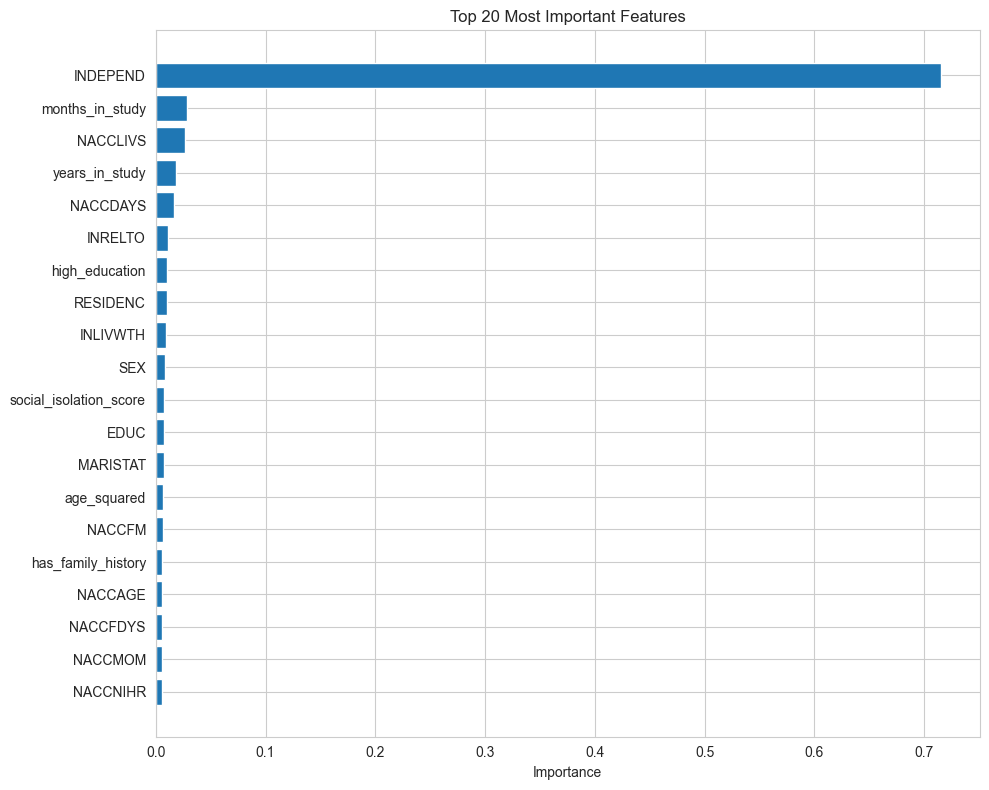

                   Feature  Importance
12                INDEPEND    0.715031
39         months_in_study    0.028346
11                NACCLIVS    0.027032
38          years_in_study    0.018220
0                 NACCDAYS    0.016385
17                 INRELTO    0.011552
32          high_education    0.010175
13                RESIDENC    0.010122
18                INLIVWTH    0.009105
4                      SEX    0.008419
35  social_isolation_score    0.007530
9                     EDUC    0.007513
10                MARISTAT    0.007215
26             age_squared    0.006640
24                  NACCFM    0.006524
37      has_family_history    0.006154
2                  NACCAGE    0.005857
1                 NACCFDYS    0.005824
20                 NACCMOM    0.005719
7                 NACCNIHR    0.005692


In [50]:
# See which features matter most
import matplotlib.pyplot as plt

# Get feature importance
importances = trained_models['XGBoost']['model'].feature_importances_
feature_names = X.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 20
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('outputs/feature_importance.png', dpi=300)
plt.show()

print(importance_df.head(20))

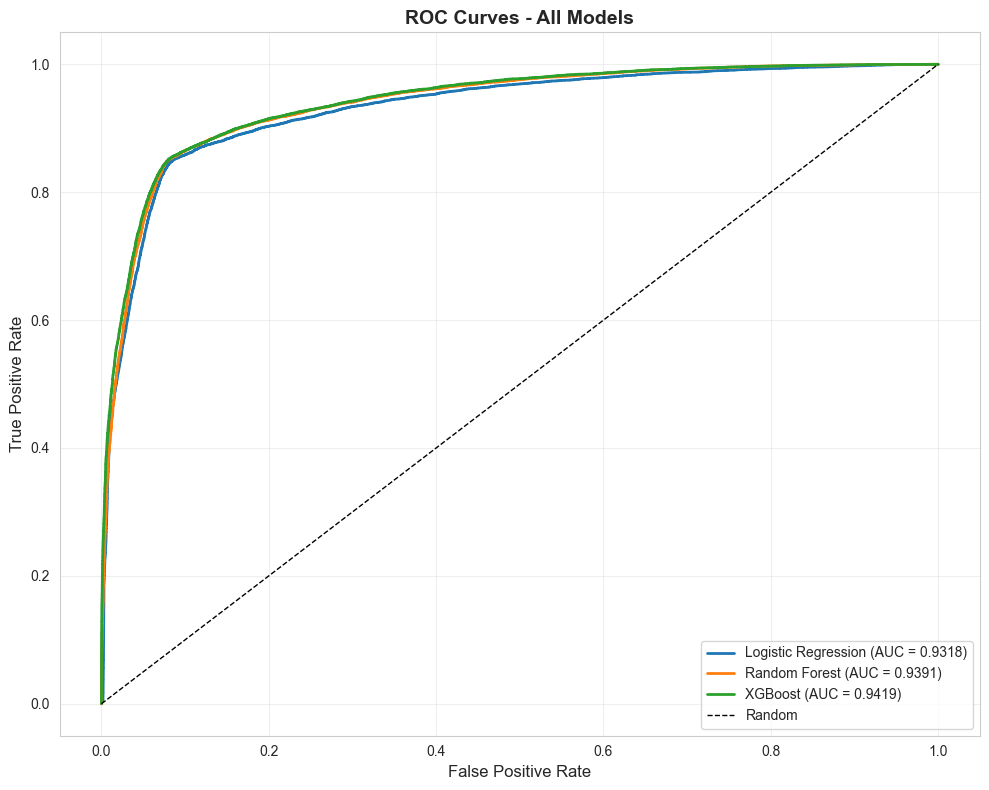

In [51]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

for name, data in trained_models.items():
    fpr, tpr, _ = roc_curve(y_test, data['probabilities'])
    auc = results_df[results_df['Model'] == name]['Test_AUC'].values[0]
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/roc_curves.png', dpi=300)
plt.show()